# COVID-19 Pre-processing Pipeline

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib.image as mpimg
import time
from PIL import Image
import os
import json
import cv2
import tqdm

In [2]:
NP_SAVE_DIR = "/Users/jxiang/Dropbox/Covid-Thermal-Images-MIT-Tec/back_image_np_files"
THERMAL_VID_FILES_DIR = "/Users/jxiang/Dropbox/Covid-Thermal-Images-MIT-Tec/np_files"

In [3]:
COVID_FILE_METADATA_PATH = "/Users/jxiang/Dropbox/Omega TI Analyzer/file_metadata.json"

## Save Numpy Functionality

In [4]:
def save_numpy_file(np_data, filename):
    save_path = os.path.join(NP_SAVE_DIR, filename)
    with open(save_path, 'wb') as f:
        np.save(f, np_data)

## Picking out frames from a thermal video

We seek to automate the process of getting frames from thermal videos. Some thermal videos are landscape, and some are portrait. We have found that affine registration is not the best at performing these rotations so we will define function that will rotate the images appropriately. Thus, we will handle rotational logic in this function as well.

In [5]:
def rotate_landscape_image(landscape_image, width, height):
    rotated_image = np.rot90(landscape_image, k=3)
    res = rotated_image[int((width-height)/2):int(width - (width-height)/2),:]
    min_val = np.amin(res)
    res = np.pad(res, ((0,0),(0,int(width-height))), 'constant', constant_values=np.amin(res))
    return res


In [6]:
def get_frames(thermal_np_path, frame_factor, covid_file_metadata_path):
    with open(covid_file_metadata_path) as json_file:
        covid_file_metadata = json.load(json_file)
        
        
        thermal_width, thermal_height = 384, 288
        thermal_vid = np.load(thermal_np_path)
        num_frame, height_width = thermal_vid.shape
        
        file_name = thermal_np_path.split('/')[-1]
                
        patient_metadata = covid_file_metadata[thermal_np_path.split('/')[-1]]["Quality Observation"]
        
        landscape = 'Landscape' in covid_file_metadata[thermal_np_path.split('/')[-1]]["Quality Observation"] or 'Lanscape' in covid_file_metadata[thermal_np_path.split('/')[-1]]["Quality Observation"]
        back_frame_percent = [i for i in np.arange(frame_factor - 0.07, frame_factor + 0.07, 0.01)]
        back_frame = [int(i * num_frame) for i in back_frame_percent]

        if landscape:
            thermal_backs = [rotate_landscape_image(np.reshape(thermal_vid[frame], (thermal_height, thermal_width)), thermal_width, thermal_height) for frame in back_frame]
        else:
            thermal_backs = [np.reshape(thermal_vid[frame], (thermal_height, thermal_width)) for frame in back_frame]
    
    return thermal_backs

In [36]:
get_frames('/Users/jxiang/Dropbox/Covid-Thermal-Images-MIT-Tec/np_files/2020-09-01_131132.IRS.npy', back_frame_factor, COVID_FILE_METADATA_PATH)

KeyError: '2020-09-01_131132.IRS.npy'

We will designate one thermal image as our template and align other thermal images to it using affine registration. For each thermal video, we will look at 4 differents views: front, back and the two sides. Since all the subjects are instructed to follow a specific order, we can automatically extract relenvant frames.

In [7]:
thermal_template_path = "/Users/jxiang/Dropbox/Covid-Thermal-Images-MIT-Tec/np_files/2020-08-12_130643.IRS.npy"

front_frame_factor = 0.07
back_frame_factor = 0.69
left_frame_factor = 0.35
right_frame_factor = 0.93

In [8]:
test_thermal_path = "/Users/jxiang/Dropbox/Covid-Thermal-Images-MIT-Tec/np_files/2020-07-31_112615.IRS.npy"

test_thermal_back = get_frames(test_thermal_path, back_frame_factor, COVID_FILE_METADATA_PATH)[2]

In [8]:
back_thermal_template = get_frames(thermal_template_path, back_frame_factor, COVID_FILE_METADATA_PATH)[3]
front_thermal_template = get_frames(thermal_template_path, front_frame_factor, COVID_FILE_METADATA_PATH)[2]
left_thermal_template = get_frames(thermal_template_path, left_frame_factor, COVID_FILE_METADATA_PATH)[4]
right_thermal_template = get_frames(thermal_template_path, right_frame_factor, COVID_FILE_METADATA_PATH)[2]

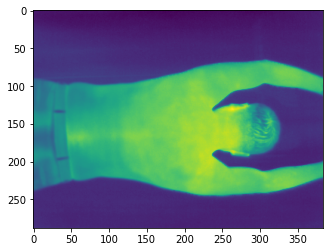

In [9]:
plt.imshow(back_thermal_template)

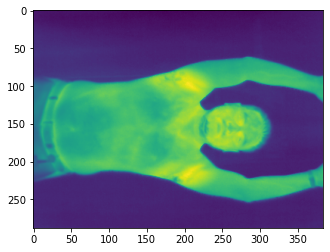

In [10]:
plt.imshow(front_thermal_template)

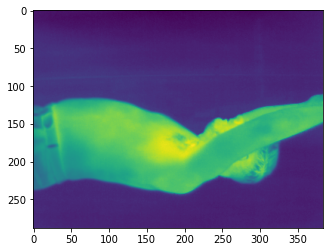

In [11]:
plt.imshow(left_thermal_template)

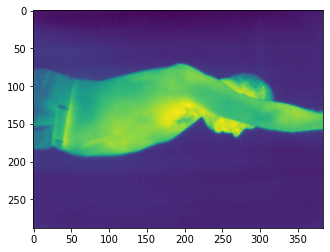

In [12]:
plt.imshow(right_thermal_template)

We will use the above image as a template for affine registration

## Affine Registration 

In [14]:
import align as al
import align.loss.factory as loss_factory
import align.regularization.factory as regularizer_factory
import SimpleITK as sitk
import torch as th

Within affine registration, parameters that can be toggled in order to achieve better registration are the type of loss function and also the number of iterations. Loss functions include: 
 - mse: Mean Squared Error
 - ncc: Normalized Cross Correlation
 - lcc: Local Normalied Cross Correlation
 - mi: Mutual Information
 - ngf: Normalized Gradient Fields
 - ssim: Structural Similarity Image Measure Loss

From trying different loss functions and visualizing the warped images, I found lcc to work best. I set number of iterations to be 50 because I did not want to overly distort the original image that much. Sometimes, a higher number of iterations results in a very blurred image.

In [15]:
def affine_registration(fixed_image_np, moving_image_np):
    fixed_image = sitk.GetImageFromArray(fixed_image_np)
    moving_image = sitk.GetImageFromArray(moving_image_np)
    fixed_image = al.utils.image_utils.create_tensor_image_from_itk_image(fixed_image)
    moving_image = al.utils.image_utils.create_tensor_image_from_itk_image(moving_image)
    
    fixed_min = fixed_image.image.min()
    moving_min = moving_image.image.min()
    
    fixed_max = fixed_image.image.max() - fixed_min
    moving_max = moving_image.image.max() - moving_min 
    
#     normalize_min = min(fixed_image.image.min(), moving_image.image.min())
#     normalize_max = max(fixed_image.image.max(), moving_image.image.max()) - normalize_min
    
    fixed_image, moving_image = al.image_filters.normalize_images(fixed_image, moving_image)

    # convert intensities so that the object intensities are 1 and the background 0. This is important in order to
    # calculate the center of mass of the object
    fixed_image.image = 1 - fixed_image.image
    moving_image.image = 1 - moving_image.image

    # create pairwise registration object
    registration = al.registration.PairwiseRegistration(verbose=False)

    # choose the affine transformation model
    transformation = al.transform.transform.SimilarityTransformation(moving_image, opt_cm=True)
    # initialize the translation with the center of mass of the fixed image
    transformation.init_translation(fixed_image)

    registration.set_transformation(transformation)

    image_loss = al.loss.ncc.NCC(fixed_image, moving_image)

    registration.set_image_loss([image_loss])

    # choose the Adam optimizer to minimize the objective
    optimizer = th.optim.LBFGS(transformation.parameters(), lr=0.01)

    registration.set_optimizer(optimizer)
    registration.set_number_of_iterations(100)

    # start the registration
    registration.start()

    # set the intensities back to the original for the visualisation
    fixed_image.image = 1 - fixed_image.image
    moving_image.image = 1 - moving_image.image

    # warp the moving image with the final transformation result
    displacement = transformation.get_displacement()
    warped_image = al.transform.utils.warp_image(moving_image, displacement)
        
    return fixed_image, moving_image, warped_image, fixed_max, fixed_min, moving_max, moving_min, registration.loss
        

In [16]:
def plot_affine(images):
      # plot the results
        index  = 1
        for fixed_image, moving_image, warped_image in images:
            plt.subplot(5,3,index)
            plt.imshow(fixed_image.numpy())
            plt.title('Fixed Image')

            plt.subplot(5,3,index+1)
            plt.imshow(moving_image.numpy())
            plt.title('Moving Image')

            plt.subplot(5,3,index+2)
            plt.imshow(warped_image.numpy())
            plt.title('Warped Image')
            
            index += 3
        
        fig_size = plt.gcf().get_size_inches() #Get current size
        sizefactor = 3 #Set a zoom factor
        # Modify the current size by the factor
        plt.gcf().set_size_inches(sizefactor * fig_size) 

        plt.show

We need to unnormalize the images so that they have their original temperature values.

In [17]:
def unnormalize_image(image, normalize_max, normalize_min):
    image.image *= normalize_max 
    image.image += normalize_min
    return image

In [18]:
def screen_frames(test_thermal, thermal_template):
    image_list = []
    loss_list = []
    for test_image in test_thermal:
        fixed_image, moving_image, warped_image, fixed_max, fixed_min, moving_max, moving_min, loss = affine_registration(thermal_template, test_image)
        unnormalized_fixed_image = unnormalize_image(fixed_image, fixed_max, fixed_min)
        unnormalized_moving_image = unnormalize_image(moving_image, moving_max, moving_min)
        unnormalized_warped_image = unnormalize_image(warped_image, moving_max, moving_min)
        image_list.append((unnormalized_fixed_image, unnormalized_moving_image, unnormalized_warped_image)) 
        loss_list.append(loss)
    
    return image_list[np.argmin(loss_list)]

In [63]:
files = os.listdir(THERMAL_VID_FILES_DIR)

IRS_files = [f for f in files if 'IRS' in f]

test_indices = np.random.randint(len(IRS_files), size=5)
test_examples = [os.path.join(THERMAL_VID_FILES_DIR, IRS_files[i]) for i in test_indices]

print("TEST EXAMPLES: ", test_examples)

TEST EXAMPLES:  ['/Users/jxiang/Dropbox/Covid-Thermal-Images-MIT-Tec/np_files/2020-08-05_130941.IRS.npy', '/Users/jxiang/Dropbox/Covid-Thermal-Images-MIT-Tec/np_files/2020-08-05_134414.IRS.npy', '/Users/jxiang/Dropbox/Covid-Thermal-Images-MIT-Tec/np_files/2020-07-31_130741.IRS.npy', '/Users/jxiang/Dropbox/Covid-Thermal-Images-MIT-Tec/np_files/2020-08-13_122458.IRS.npy', '/Users/jxiang/Dropbox/Covid-Thermal-Images-MIT-Tec/np_files/2020-07-28_111002.IRS.npy']


TypeError: argument of type 'NoneType' is not iterable

In [64]:
warped_test_images = []

for example in tqdm.tqdm(test_examples):
    test_thermal = get_frames(example, back_frame_factor, COVID_FILE_METADATA_PATH)
    warped_test = screen_frames(test_thermal, back_thermal_template)
    warped_test_images.append(warped_test)

100%|██████████| 5/5 [12:18<00:00, 147.76s/it]


In [65]:
front_warped_test_images = []

for example in tqdm.tqdm(test_examples):
    test_thermal = get_frames(example, front_frame_factor, COVID_FILE_METADATA_PATH)
    warped_test = screen_frames(test_thermal, front_thermal_template)
    front_warped_test_images.append(warped_test)

100%|██████████| 5/5 [13:02<00:00, 156.52s/it]


In [66]:
right_warped_test_images = []

for example in tqdm.tqdm(test_examples):
    test_thermal = get_frames(example, right_frame_factor, COVID_FILE_METADATA_PATH)
    warped_test = screen_frames(test_thermal, right_thermal_template)
    right_warped_test_images.append(warped_test)

100%|██████████| 5/5 [12:58<00:00, 155.77s/it]


In [67]:
left_warped_test_images = []

for example in tqdm.tqdm(test_examples):
    test_thermal = get_frames(example, left_frame_factor, COVID_FILE_METADATA_PATH)
    warped_test = screen_frames(test_thermal, left_thermal_template)
    left_warped_test_images.append(warped_test)

100%|██████████| 5/5 [11:14<00:00, 134.95s/it]


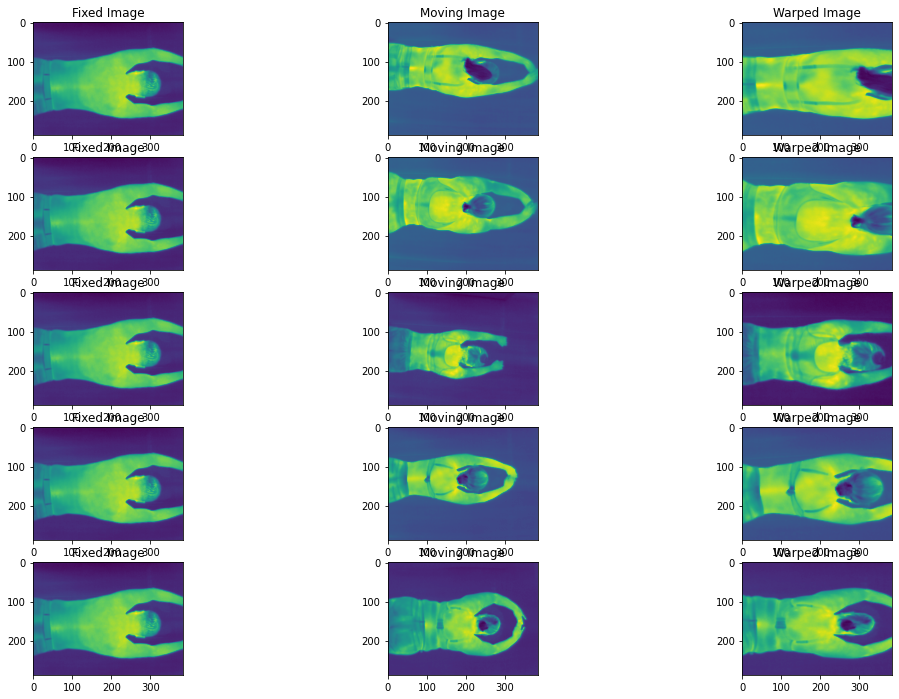

In [68]:
plot_affine(warped_test_images)

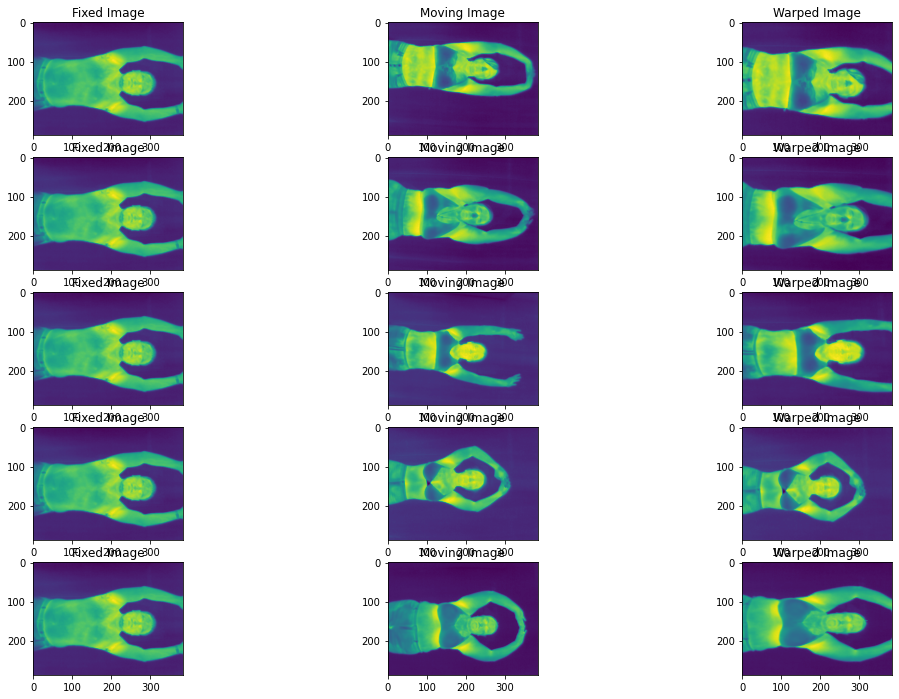

In [69]:
plot_affine(front_warped_test_images)

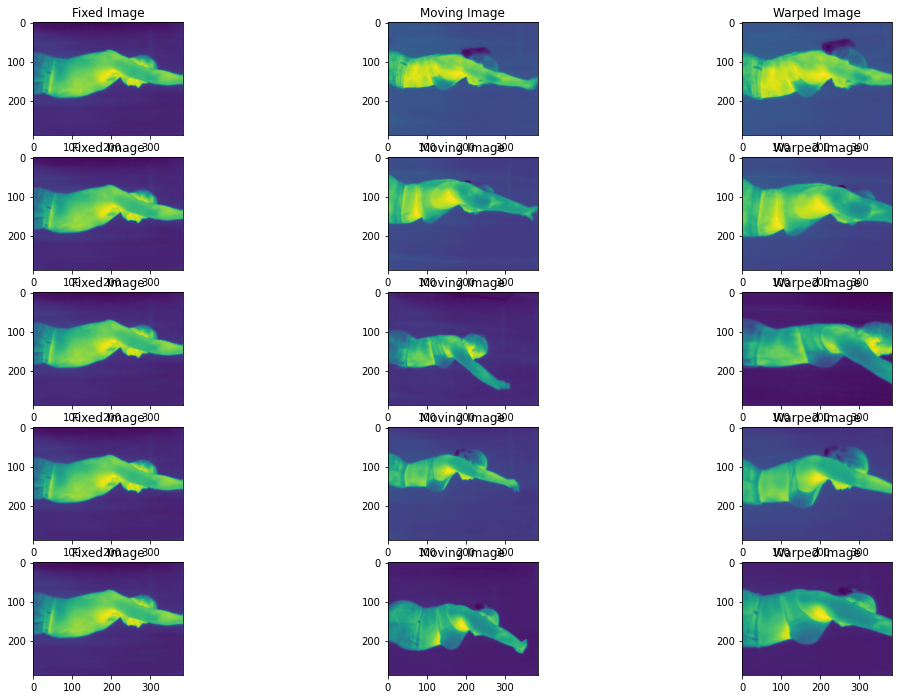

In [70]:
plot_affine(right_warped_test_images)

In [71]:
fixed_image, moving_image, warped_image, fixed_max, fixed_min, moving_max, moving_min, loss = affine_registration(back_thermal_template, test_thermal_back)

In [ ]:
unnormalized_fixed_image = unnormalize_image(fixed_image, fixed_max, fixed_min)
unnormalized_moving_image = unnormalize_image(moving_image, moving_max, moving_min)
unnormalized_warped_image = unnormalize_image(warped_image, moving_max, moving_min)

In [ ]:
plt.imshow(fixed_image.numpy())

In [ ]:
plt.imshow(moving_image.numpy())

In [ ]:
plt.imshow(warped_image.numpy())

Below is an example of a fixed image (template image), moving image (thermal image to be transformed), and the warped image.

In [ ]:
plot_affine(unnormalized_fixed_image, unnormalized_moving_image, unnormalized_warped_image)

## Converting videos to back frame images

In [ ]:
def convert_video_to_back_frame(thermal_template_path, thermal_moving_path):
    template_filename = os.path.join(THERMAL_VID_FILES_DIR, thermal_template_path)
    moving_filename = os.path.join(THERMAL_VID_FILES_DIR, thermal_moving_path)
    
    thermal_template = get_back_frames(template_filename)
    thermal_moving = get_back_frames(moving_filename)
    
    plt.imshow(thermal_moving)
    
    fixed_image, moving_image, warped_image, normalize_min, normalize_max = affine_registration(thermal_template, thermal_moving)
    
    unnormalized_warped_image = unnormalize_image(warped_image, normalize_max, normalize_min)
    unnormalized_warped_np = unnormalized_warped_image.numpy()
    
    plot_affine(fixed_image, moving_image, warped_image)
    
    save_numpy_file(unnormalized_warped_np, thermal_moving_path)
    
    

In [ ]:
def convert_videos_to_back_frame(thermal_template_path, thermal_images_dir):
    for _,_,files in os.walk(thermal_images_dir):
        for f in files:
            print(f)
            if f.split('.')[-2] == 'IRS':
                convert_video_to_back_frame(thermal_template_path, f)
        

In [ ]:
thermal_template_path = "2020-08-18_122318.IRS.npy"
thermal_images_dir = THERMAL_VID_FILES_DIR

convert_videos_to_back_frame(thermal_template_path, thermal_images_dir)

## Sample Points

### Sample Lower Back Point

In [ ]:
def sample_lower_back_point():
    pass

### Sample Upper Back Point

In [ ]:
def sample_lower_back_point():
    pass

### Sample Ambient Temperature Point

In [ ]:
def sample_ambient_temperature():
    pass

In [ ]:
np.min(warped_image.numpy())